# ITA 2021 - HistGB Paralelo


## Resumo/Roadmap

*   Normalização: Nenhuma
*   Algoritmo: GradientBoostingRegressor
*   Método "paralelo": cada variável-alvo será trabalhada independentemente.

## Configuração do Cliente DataJudge

In [1]:
# Instalando a API do Cliente Python do sistema DataJudge
!pip install datajudge-client

In [2]:
# Configurando a chave APIcomo variável de ambiente
# Chave da equipe Bust
%env TEAM_KEY = MfMcBlDPmstwUu6KbOvvMID9McmgAyiR

env: TEAM_KEY=MfMcBlDPmstwUu6KbOvvMID9McmgAyiR


In [3]:
# Testando o acesso com a chave
!python -m datajudge-client --key $TEAM_KEY teamname

"Bust UFSJ"


## Imports

In [ ]:
import numpy as np              # operações numéricas
import pandas as pd             # manipulação de dados em dataframes
import matplotlib.pyplot as plt # plots gráficos
#import seaborn as sns           # plots estatísticos

import os   # funções de sistema operacional

In [ ]:
# Montar o Drive (com autenticação)
if not os.path.exists('/content/drive/'):
  from google.colab import drive
  drive.mount('/content/drive/')

## Data Gathering

In [ ]:
# Coletando dados de treino e teste para dataset pandas
train_path = '/content/drive/MyDrive/Colab Notebooks/Competição_ITA_2021/ITA_2021/Dados/public-train.csv'
test_path  = '/content/drive/MyDrive/Colab Notebooks/Competição_ITA_2021/ITA_2021/Dados/public-test.csv'

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

In [ ]:
df_train.head(), df_test.head()

(     n    p    f   x   y  ...   l4   e1   e2  cent_price_cor  cent_trans_cor
 0  709  0.7  0.2  16  12  ...  1.6  1.5  2.6          -0.169           0.375
 1  921  0.6  0.3  19  17  ...  1.8  0.6  0.4          -0.075           0.234
 2  177  0.8  0.4  14  12  ...  0.6  2.7  0.3          -0.177           0.389
 3  415  0.7  0.5  24  11  ...  1.1  0.5  0.1          -0.102           0.358
 4  802  0.8  0.4  21  10  ...  1.1  2.0  0.6          -0.034           0.180
 
 [5 rows x 28 columns],
    id    n    p    f   x   y  z  ...   g2     l1   l2     l3   l4   e1   e2
 0   1  558  0.5  0.2  28  21  2  ...  1.8  0.149  2.0  0.078  1.7  0.5  2.9
 1   2  910  0.9  0.3  28  19  9  ...  1.0  0.086  0.8  0.030  0.8  0.2  1.6
 2   3  213  0.8  0.5  21  15  8  ...  0.7  0.019  1.4  0.016  1.2  2.6  2.4
 3   4  654  0.7  0.5  14  15  2  ...  1.3  0.110  0.8  0.006  1.7  0.2  1.7
 4   5  672  0.7  0.5  24  10  5  ...  0.9  0.148  1.9  0.038  1.3  1.1  2.8
 
 [5 rows x 27 columns])

## Análise Rápida

In [ ]:
# Espaço para uma eventual análise dos dados
df_train['p'].skew()  # Teste de normalidade

-0.007356222293995963

## Data Preparation

In [ ]:
# 2 variáveis-alvo: método simultâneo
X_train = df_train.iloc[:,:-2].values
y1_train = df_train.iloc[:,-2].values 
y2_train = df_train.iloc[:,-1].values

X_test = df_test.iloc[:,1:].values

## Machine Learning

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Treinando e Testando o modelo 1
params = {}   # Configuração dos parâmetros do modelo
reg_1 = GradientBoostingRegressor(**params) # Método paralelo
reg_1.fit(X_train, y1_train)       # Treino do modelo
y1_pred = reg_1.predict(X_test)    # Teste do modelo

In [ ]:
y1_pred[:5]   # Prévia das predições

array([-0.18638336, -0.2106696 , -0.2090447 , -0.2067519 , -0.20301334])

In [ ]:
# Treinando e Testando o modelo 2
params = {}   # Configuração dos parâmetros do modelo
reg_2 = GradientBoostingRegressor(**params) # Método paralelo
reg_2.fit(X_train, y2_train)       # Treino do modelo
y2_pred = reg_2.predict(X_test)    # Teste do modelo

In [ ]:
y2_pred[:5]   # Prévia das predições

array([0.3624796 , 0.38016558, 0.36871388, 0.3650605 , 0.36045514])

### Validation

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [ ]:
# Cross-validation - modelo 1
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
np.mean(cross_val_score(reg_1, X_train, y1_train, scoring='neg_mean_absolute_error', cv=cv))

-0.09434299293484498

In [ ]:
# Cross-validation - modelo 2
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
np.mean(cross_val_score(reg_2, X_train, y2_train, scoring='neg_mean_absolute_error', cv=cv))

-0.0909715217124468

### Ajustando Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Parâmetros do modelo
params = {
    'learning_rate': 0.0001,
    'warm_start': True
}

# Parâmetros a serem testados
param_grid = [{
    'validation_fraction': [0.001, 0.004, 0.005, 0.006, 0.007, 0.008]
}]

In [ ]:
reg_1 = GradientBoostingRegressor(**params)
reg_2 = GradientBoostingRegressor(**params)

grid_1 = GridSearchCV(reg_1, param_grid)
grid_2 = GridSearchCV(reg_2, param_grid)

In [ ]:
grid_1.fit(X_train, y=y1_train)
grid_2.fit(X_train, y=y2_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None,
                                                 learning_rate=0.0001,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                  

In [ ]:
grid_1.best_params_, grid_1.best_score_

({'validation_fraction': 0.001}, -0.166267049073147)

In [ ]:
grid_2.best_params_, grid_2.best_score_

({'validation_fraction': 0.008}, -0.11449871770041153)

### Treinando novamente

In [ ]:
param_1 = {**params, **grid_1.best_params_}
param_2 = {**params, **grid_2.best_params_}

In [ ]:
reg_1 = GradientBoostingRegressor(**param_1)
reg_2 = GradientBoostingRegressor(**param_2)

In [ ]:
# Treinando o modelo novamente
reg_1.fit(X_train, y1_train)
reg_2.fit(X_train, y2_train)

# Predições novas
y1_pred_new = reg_1.predict(X_test)
y2_pred_new = reg_2.predict(X_test)

In [ ]:
y1_pred_new[:5], y2_pred_new[:5]

(array([-0.20260597, -0.20251842, -0.20265158, -0.20260597, -0.20260597]),
 array([0.36255732, 0.3626412 , 0.3626412 , 0.36255732, 0.3626412 ]))

### Pontuação de validação

In [ ]:
# Cross-validation - modelo 1
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
np.mean(cross_val_score(reg_1, X_train, y1_train, scoring='neg_mean_absolute_error', cv=cv))

-0.09382665195937082

In [ ]:
# Cross-validation - modelo 2
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
np.mean(cross_val_score(reg_2, X_train, y2_train, scoring='neg_mean_absolute_error', cv=cv))

-0.0904269752339273

## Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve, ShuffleSplit

In [ ]:
# Função para plotar curvas de aprendizado do modelo
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    # Configuração dos Eixos
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    # Obtenção das curvas de aprendizado
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

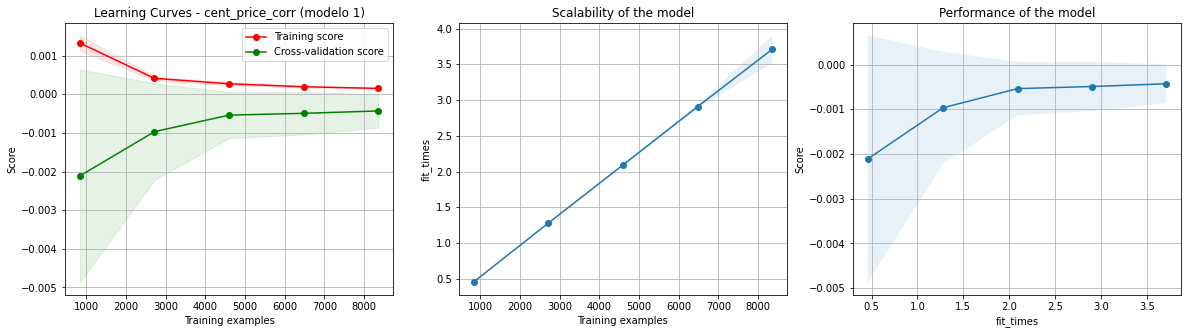

In [ ]:
# Cross validation with 20 iterations, each time with 20% data randomly selected as a validation set
title = "Learning Curves - cent_price_corr (modelo 1)"

cv = ShuffleSplit(n_splits=20, test_size=0.3, random_state=0) 
plot_learning_curve(reg_1, title, X_train, y1_train, cv=cv, n_jobs=-1)

plt.show()

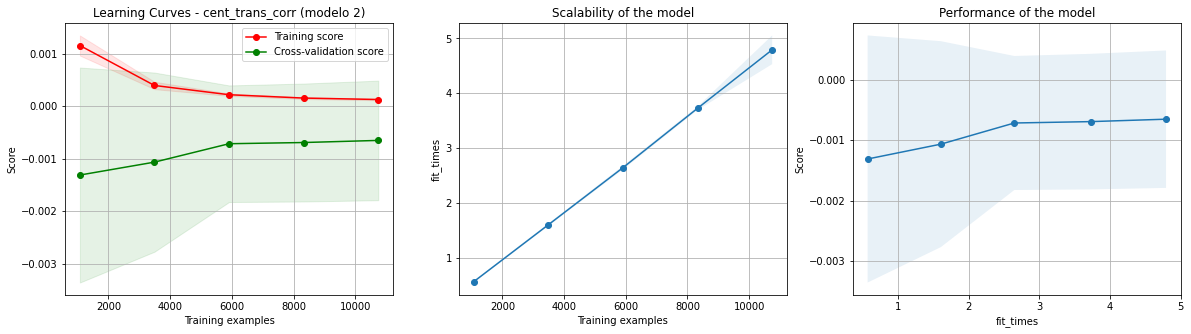

In [ ]:
# Cross validation with 20 iterations, each time with 20% data randomly selected as a validation set
title = "Learning Curves - cent_trans_corr (modelo 2)"

cv = ShuffleSplit(n_splits=20, test_size=0.1, random_state=0) 
plot_learning_curve(reg_2, title, X_train, y2_train, cv=cv, n_jobs=-1)

plt.show()

## Salvando arquivo

In [ ]:
df_sub = pd.DataFrame({'cent_price_cor': y1_pred_new, 'cent_trans_cor': y2_pred_new})

In [ ]:
df_sub.shape

(8059, 2)

In [ ]:
df_sub.head()

,cent_price_cor,cent_trans_cor
0,-0.202606,0.362557
1,-0.202518,0.362641
2,-0.202652,0.362641
3,-0.202606,0.362557
4,-0.202606,0.362641


In [ ]:
# para arquivo submission_*.csv
submission_save_path = '/content/drive/MyDrive/Colab Notebooks/Competição_ITA_2021/ITA_2021/EquipeBust/GradientBoosting/sub_GB_Prl_GridNew.csv'
df_sub.to_csv(submission_save_path, index=False)

## Submissão

In [ ]:
!python -m datajudge-client --key $TEAM_KEY submit --input '/content/drive/MyDrive/Colab Notebooks/Competição_ITA_2021/ITA_2021/EquipeBust/GradientBoosting/sub_GB_Prl_GridNew.csv'

{'score': 0.184597, 'timestamp': '2021-05-17T18:10:31Z'}


In [4]:
# Checando o ranking
!python -m datajudge-client --key $TEAM_KEY leaderboard --format '{team:30s} {score:10.6f} {timestamp}'

AtLeastWeTried                   0.180872 2021-05-17T21:57:43Z
LSI Data Team                    0.184300 2021-05-17T15:52:47Z
Otakus do DataScience            0.184313 2021-05-17T01:24:13Z
Rama                             0.184421 2021-05-17T02:56:46Z
Pandemonios                      0.184429 2021-05-17T23:09:20Z
Dev. Community Maua              0.184454 2021-05-17T21:38:27Z
Bust UFSJ                        0.184533 2021-05-17T18:10:31Z
Lattes                           0.184546 2021-05-17T13:34:37Z
Victor P                         0.184550 2021-05-17T16:56:47Z
Php                              0.184570 2021-05-11T12:32:49Z
My Awesome Team                  0.184624 2021-05-10T12:22:44Z
UFRJ Analytica                   0.184790 2021-05-12T00:34:10Z
Gustavo Bertoli                  0.185108 2021-05-17T21:21:53Z
Pyneapple                        0.185937 2021-05-10T20:45:49Z
Zangoes                          0.186503 2021-05-17T21:12:03Z
Marimbondos                      0.192517 2021-05-12T11

## Atualizando Submit_History

In [ ]:
# Lendo o arquivo submit_history
sub_hist_path = '/content/drive/MyDrive/Colab Notebooks/Competição_ITA_2021/ITA_2021/submit_history.csv'
subs = pd.read_csv(sub_hist_path)

In [ ]:
subs.head()

,Equipe,DataHora,Score,Descricao,Arquivo
0,Bust,08-05-2021 13:44,0.186359,Teste da chave API,submission_test.csv
1,ML,08-05-2021 18:30,0.194000,Teste da chave API,NaN
2,Bust,10-05-2021 01:45,0.186359,Teste Método Paralelo,submission_HistGB_Prl.csv
3,Bust,10-05-2021 23:01,0.184598,Implem. GridSearch com HistGB Paralelo,submission_HistGB_Prl_Grid.csv
4,Bust,12-05-2021 11:39,0.185021,GridSearch com HistGB Sequencial,sub_HistGB_Seq_Grid.csv


In [ ]:
# Dados sobre o submit a ser inserido no arquivo
input_submit = {
    'Equipe':     'Bust',
    'DataHora':   '17-05-2021 15:10',
    'Score':       0.184597,
    'Descricao':  'GridSearch com GB Paralelo Novo',
    'Arquivo':    'sub_GB_Prl_GridNew.csv'
}
subs = subs.append(input_submit, ignore_index=True)

In [ ]:
# Salvando o arquivo submit_history
subs.to_csv(sub_hist_path, index=False)